# Myers–Briggs Type Indicator (MBTI) Personality Prediction

## Libraries and Global Settings

In [11]:
import re
import os
import spacy
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

from ipywidgets import widgets, interact
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

# python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

warnings.filterwarnings('ignore')

## Import Dataset

In [3]:
if not os.path.isfile("mbti_normalized.csv"):
    df = pd.read_csv('mbti_1.csv', encoding='utf8')
else:
    df = pd.read_csv('mbti_normalized.csv', encoding='utf8')

In [6]:
df.head(10)

type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...
5  INTJ  '18/37 @.@|||Science  is not perfect. No scien...
6  INFJ  'No, I can't draw on my own nails (haha). Thos...
7  INTJ  'I tend to build up a collection of things on ...
8  INFJ  I'm not sure, that's a good question. The dist...
9  INTP  'https://www.youtube.com/watch?v=w8-egj0y8Qs||...

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


## Data Visualization

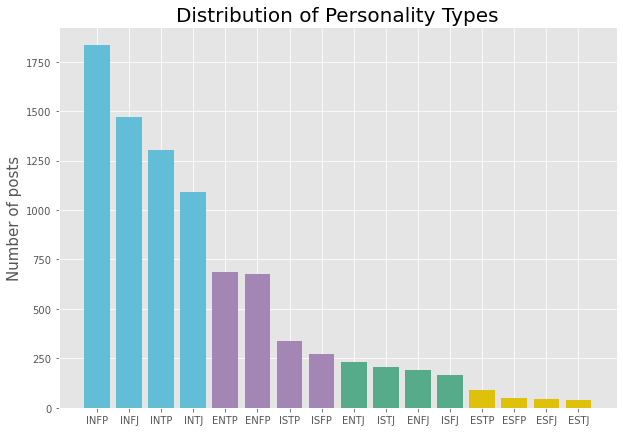

In [8]:
#Variables
data_path = os.path.join('..','data')
img_path = os.path.join('static','images')

nt = "#61BED6"
nf = "#A386B4"
sj = "#56AC8A"
sp = "#DFC10C"

colors_d = {
    'ENTP':nt,
    'INTP':nt,
    'INTJ':nt,
    'ENTJ':nt,
    'INFJ':nf,
    'ENFJ':nf,
    'INFP':nf,
    'ENFP':nf,
    'ISFJ':sj,
    'ISTJ':sj,
    'ESTJ':sj,
    'ESFJ':sj,
    'ISFP':sp,
    'ISTP':sp,
    'ESTP':sp,
    'ESFP':sp
    }

df.columns.tolist()
mb = df.groupby('type').agg({'type':'count'}).rename(columns={'type':'count'}).sort_values('count',ascending=False)
sorted(colors_d.items(), key=lambda pair: mb.index.tolist().index(pair[0]))
plt.figure(figsize=(10,7))
plt.title("Distribution of Personality Types", fontsize=20)
plt.ylabel("Number of posts", fontsize=15)
plt.bar(mb.index, mb['count'], color=list(colors_d.values()))
plt.savefig(os.path.join(img_path,"type_hist.png"))
plt.show()

In [9]:
def var_row(row):
    l = []
    for i in row.split('|||'):
        l.append(len(i.split()))
    return np.var(l)

df['words_per_comment'] = df['posts'].apply(lambda x: len(x.split())/50)
df['variance_of_word_counts'] = df['posts'].apply(lambda x: var_row(x))
df.head()

type                                              posts  words_per_comment  \
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...              11.12   
1  ENTP  'I'm finding the lack of me in these posts ver...              23.40   
2  INTP  'Good one  _____   https://www.youtube.com/wat...              16.72   
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...              21.28   
4  ENTJ  'You're fired.|||That's another silly misconce...              19.34   

   variance_of_word_counts  
0                 135.2900  
1                 187.4756  
2                 180.6900  
3                 181.8324  
4                 196.4576

<AxesSubplot:xlabel='type', ylabel='words_per_comment'>

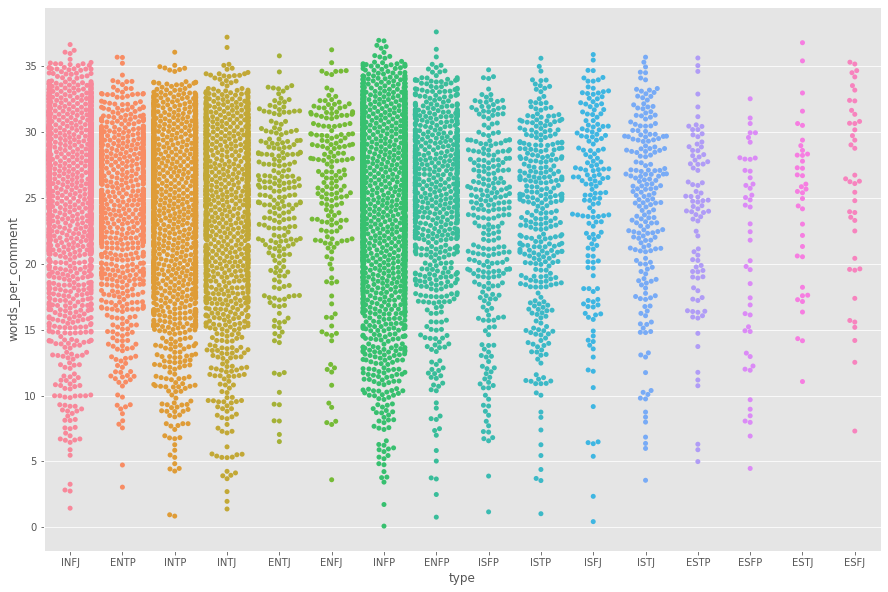

In [12]:
plt.figure(figsize=(15,10))
sns.swarmplot("type", "words_per_comment", data=df)

In [13]:
df.groupby('type').agg({'type':'count'})

type
type      
ENFJ   190
ENFP   675
ENTJ   231
ENTP   685
ESFJ    42
ESFP    48
ESTJ    39
ESTP    89
INFJ  1470
INFP  1832
INTJ  1091
INTP  1304
ISFJ   166
ISFP   271
ISTJ   205
ISTP   337

In [14]:
df_2 = df[~df['type'].isin(['ESFJ','ESFP','ESTJ','ESTP'])]
df_2['http_per_comment'] = df_2['posts'].apply(lambda x: x.count('http')/50)
df_2['qm_per_comment'] = df_2['posts'].apply(lambda x: x.count('?')/50)
df_2.head()

type                                              posts  words_per_comment  \
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...              11.12   
1  ENTP  'I'm finding the lack of me in these posts ver...              23.40   
2  INTP  'Good one  _____   https://www.youtube.com/wat...              16.72   
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...              21.28   
4  ENTJ  'You're fired.|||That's another silly misconce...              19.34   

   variance_of_word_counts  http_per_comment  qm_per_comment  
0                 135.2900              0.48            0.36  
1                 187.4756              0.20            0.10  
2                 180.6900              0.10            0.24  
3                 181.8324              0.04            0.22  
4                 196.4576              0.12            0.20

<Figure size 1080x720 with 0 Axes>

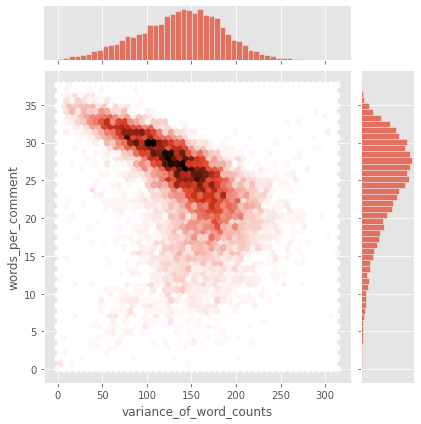

In [15]:
plt.figure(figsize=(15,10))
sns.jointplot("variance_of_word_counts", "words_per_comment", data=df_2, kind="hex")

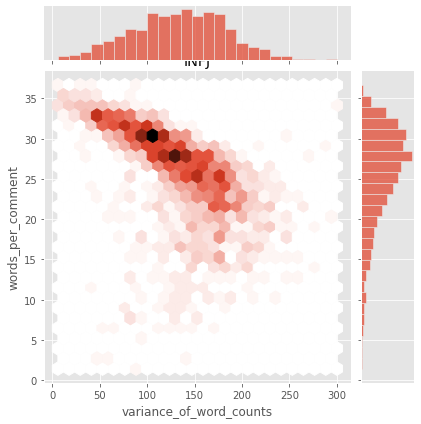

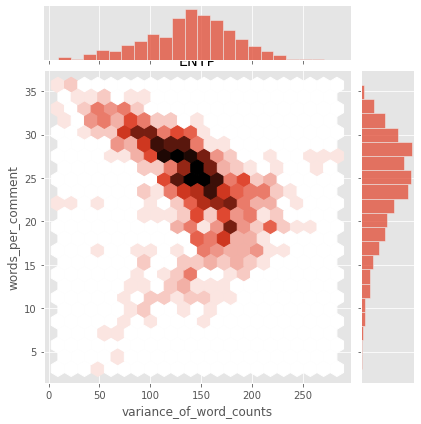

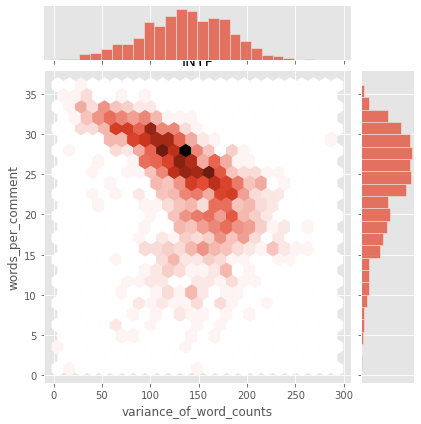

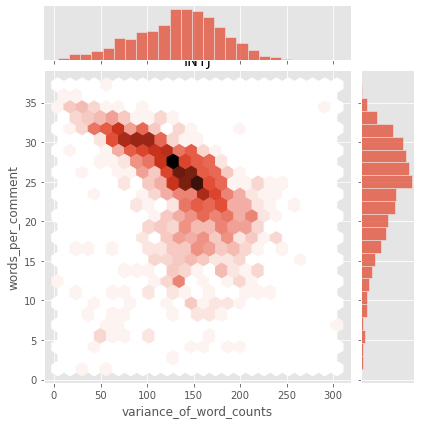

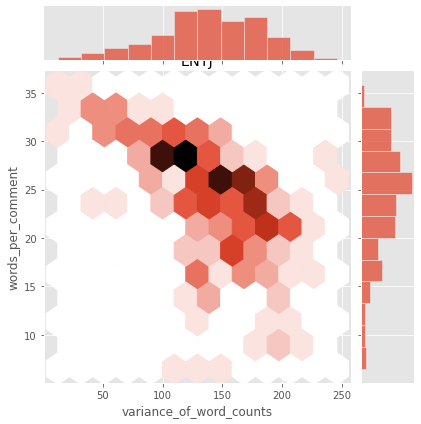

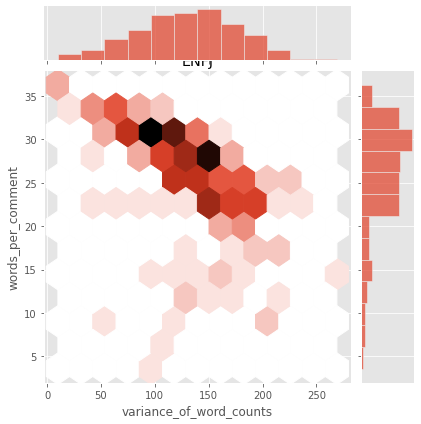

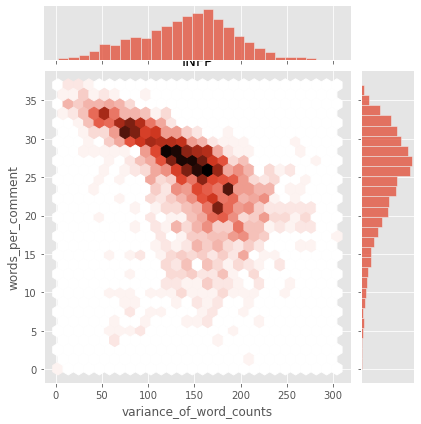

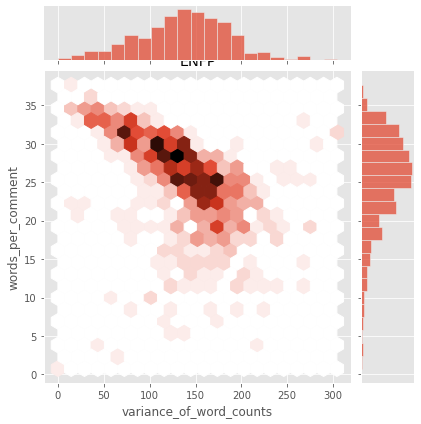

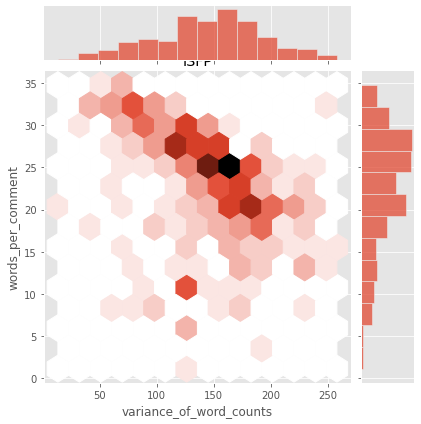

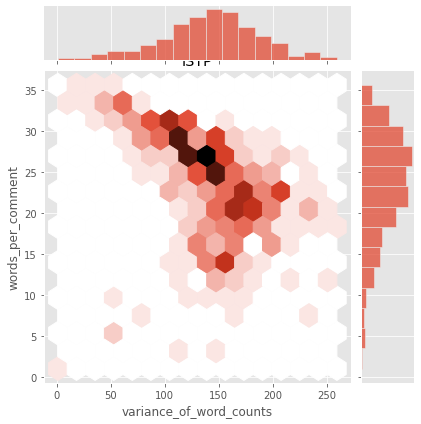

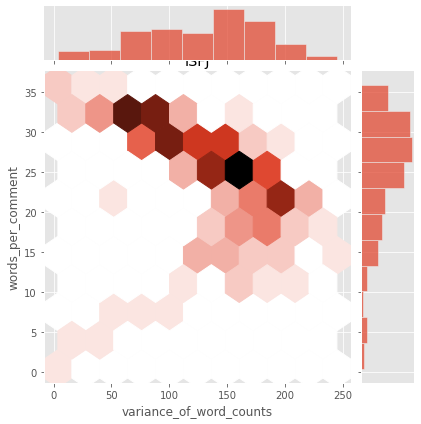

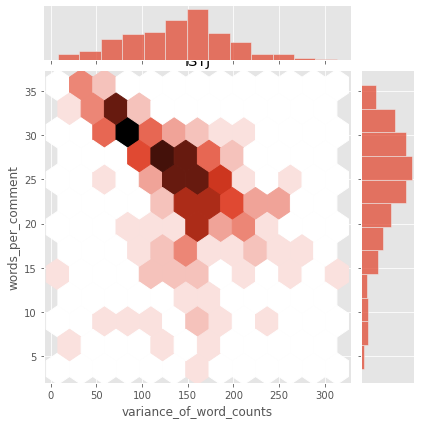

In [17]:
def plot_jointplot(mbti_type, axs, titles):
    df_3 = df_2[df_2['type'] == mbti_type]
    sns.jointplot("variance_of_word_counts", "words_per_comment", data=df_3, kind="hex", ax = axs, title = titles)
    
i = df_2['type'].unique()
k = 0
for m in range(0,2):
    for n in range(0,6):
        df_3 = df_2[df_2['type'] == i[k]]
        sns.jointplot("variance_of_word_counts", "words_per_comment", data=df_3, kind="hex")
        plt.title(i[k])
        k+=1

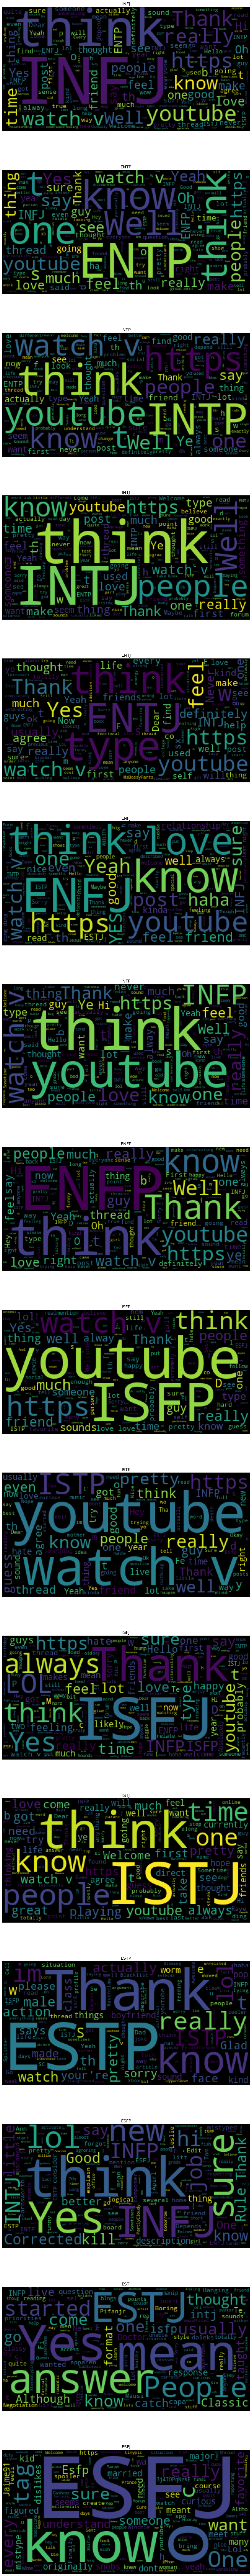

In [32]:
from imageio import imread
from wordcloud import WordCloud, STOPWORDS

fig, ax = plt.subplots(len(df['type'].unique()), sharex=True, figsize=(15,10*len(df['type'].unique())))

k = 0
for i in df['type'].unique():
    df_4 = df[df['type'] == i]
    wordcloud = WordCloud().generate(df_4['posts'].to_string())
    ax[k].imshow(wordcloud)
    ax[k].set_title(i)
    ax[k].axis("off")
    k+=1

## Preprocessing

### Text Normalization

In [5]:
def normalizer(sentence):
 
    # Remove ||| from kaggle dataset
    sentence = re.sub("[]|||[]", " ", sentence)

    # remove reddit subreddit urls
    sentence = re.sub("/r/[0-9A-Za-z]", "", sentence)

    # remove MBTI types
    MBTI_types = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
              'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ',
              'MBTI']
    MBTI_types = [ti.lower() for ti in MBTI_types] + [ti.lower() + 's' for ti in MBTI_types]

    tokens = nlp(sentence)

    tokens = [ti for ti in tokens if ti.lower_ not in STOP_WORDS]
    tokens = [ti for ti in tokens if not ti.is_space]
    tokens = [ti for ti in tokens if not ti.is_punct]
    tokens = [ti for ti in tokens if not ti.like_num]
    tokens = [ti for ti in tokens if not ti.like_url]
    tokens = [ti for ti in tokens if not ti.like_email]
    tokens = [ti for ti in tokens if ti.lower_ not in MBTI_types]


    # lemmatize
    tokens = [ti.lemma_ for ti in tokens if ti.lemma_ not in STOP_WORDS]
    tokens = [ti for ti in tokens if len(ti) > 1]
    
    text = " ".join(tokens)
    return text

In [6]:
if not os.path.isfile("mbti_normalized.csv"):
    df['normalized_text'] = df.posts.apply(normalizer)
    df.to_csv('mbti_normalized.csv')

In [7]:
df.head(5)

Unnamed: 0  type                                              posts  \
0           0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...   
1           1  ENTP  'I'm finding the lack of me in these posts ver...   
2           2  INTP  'Good one  _____   https://www.youtube.com/wat...   
3           3  INTJ  'Dear INTP,   I enjoyed our conversation the o...   
4           4  ENTJ  'You're fired.|||That's another silly misconce...   

                                     normalized_text  
0  moment sportscenter play prank life change exp...  
1  find lack post alarming sex boring position ex...  
2  good course know blessing curse absolutely pos...  
3  dear enjoy conversation day esoteric gabbe nat...  
4  fire silly misconception approach logically ke...

In [8]:
# Drop unnamed columns
df = df.drop(df.columns[0], axis=1)
df = df.drop(df.columns[1], axis=1)
df

type                                    normalized_text
0     INFJ  moment sportscenter play prank life change exp...
1     ENTP  find lack post alarming sex boring position ex...
2     INTP  good course know blessing curse absolutely pos...
3     INTJ  dear enjoy conversation day esoteric gabbe nat...
4     ENTJ  fire silly misconception approach logically ke...
...    ...                                                ...
8670  ISFP  IxFP think cat Fi dom reason especially websit...
8671  ENFP  thread exist someplace heck delete ooop guess ...
8672  INTP  question thing purple pill pick win lottery nu...
8673  INFP  conflicted right come want child honestly mate...
8674  INFP  long personalitycafe change bit good like usua...

[8675 rows x 2 columns]

### Vectorization

In [9]:
train, test = train_test_split(df, test_size=.2)

In [10]:
train

type                                    normalized_text
6522  INFP  confusion inner feeling ignore notice picture ...
3553  INTJ  leave excuse partial self promotion like know ...
6718  INFJ  time mention chance address clear mean depend ...
428   ENFP  Contra personally live debate Blair White fund...
6276  ENTP  eh type politician political argument happen a...
...    ...                                                ...
360   ENFP  hauhuhauh right Muhicz wonder step come exactl...
4189  INFJ  read comic_strip base film Professor James McA...
6519  INFP  love find think Beverly pretty typical Murray ...
3266  INFP  self confidence feel like impossible change kn...
5114  INFP  today :D amazing pretty total solar eclipse pa...

[6940 rows x 2 columns]

In [11]:
X_train = train['normalized_text']
y_train = train['type']
X_test = test['normalized_text']
y_test = test['type']

In [12]:
tf_idf = TfidfVectorizer()
X_train_tf = tf_idf.fit_transform(X_train.values.astype('U'))
X_train_tf = tf_idf.transform(X_train.values.astype('U'))

print("n_samples: %d, n_features: %d" % X_train_tf.shape)

n_samples: 6940, n_features: 80779


In [13]:
X_test_tf = tf_idf.transform(X_test.values.astype('U'))

print("n_samples: %d, n_features: %d" % X_test_tf.shape)

n_samples: 1735, n_features: 80779


In [14]:
X_train = X_train_tf
X_test = X_test_tf

In [15]:
X_test.shape

(1735, 80779)

## Machine Learning

In [15]:
if not os.path.isfile("model_lr.pickle"):
    # parameter grid
    parameters_lr = {
        'penalty' : ['l1', 'l2'], 
        'C'       : np.logspace(-4, 4, 20),
        'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
        'max_iter' : [50, 100, 1000, 2500, 5000]
    }

In [18]:
if not os.path.isfile("model_lr.pickle"):
    model_LR = GridSearchCV(LogisticRegression(), param_grid = parameters_lr, scoring='accuracy', cv=5)
    model_LR = model_LR.fit(X_train, y_train)
    print("\n model_LR: best estimator across ALL searched params:\n",model_LR.best_estimator_)
    print("\n model_LR: best parameters across ALL searched params:\n",model_LR.best_params_)


 model_LR_CON: best estimator across ALL searched params:
 LogisticRegression(C=78.47599703514607, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=50, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

 model_LR_CON: best parameters across ALL searched params:
 {'C': 78.47599703514607, 'max_iter': 50, 'penalty': 'l2', 'solver': 'newton-cg'}


**After applying GridSearchCV for the Logistic Regression model,**

* The best estimator across ALL searched params = 
            LogisticRegression(C=78.47599703514607, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=50, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
                   
* The best parameters across ALL searched params = 
            {'C': 78.47599703514607, 'max_iter': 50, 'penalty': 'l2', 'solver': 'newton-cg'}

In [16]:
model_LR = LogisticRegression(C=78.47599703514607, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=50, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
model_LR = model_LR.fit(X_train, y_train)

In [17]:
output_LR = model_LR.predict(X_test)

In [ ]:
if not os.path.isfile("model_lr.pickle"):
    # Pickle the model
    with open('model_lr.pickle', 'wb') as files:
        pickle.dump(model_LR, files)

## Evaluation

In [18]:
# Calculatingthe accuracy of the KNN model
accuracy = accuracy_score(y_test, output_LR)
accuracy

0.4207492795389049

## Example: how to use a pickled model for predictions

```
with open('model_lr.pickle', 'rb') as f:
    pickled_model_lr = pickle.load(f)

text = 'When I was just a little girl, I keep to myself, I hardly talk to people, even when I’m in school I don’t talk to my friends in class. Most times when my teacher ask me a question, she forces words out of my mouth. My mum told me all this.'

normalized_text = normalizer(text)
vectorized_text = tf_idf.transform([normalized_text])
prediction = pickled_model_lr.predict(vectorized_text)

prediction
```

## Reference
M. J, (MBTI) Myers-Briggs Personality Type Dataset, 2017, Kaggle, May 2022. [Online]. Available: https://www.kaggle.com/datasnaek/mbti-type.